## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [21]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import training_helper
from dataset_modules.one_part_dataset import OnePartDataset
import metrics_helper

importlib.reload(training_helper)
importlib.reload(metrics_helper)

<module 'metrics_helper' from '/Users/fcuevas/Documents/fing/tesis/jupyters/metrics_helper.py'>

## Variables

In [22]:
MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "alexnet_guardabarro_del_der_fine_tuning_newdata"
FEATURE_EXTRACTION = False

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

In [23]:
os.makedirs(os.path.dirname("./trained_models/{}/{}/asd.txt".format(MODEL_NAME, EXPERIMENT_NAME)), exist_ok=True)

## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [24]:
dataset = OnePartDataset(
    "Guardabarro Delantero Derecho",
    transform=transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

classes = dataset.classes

dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #916, 55.02%
Class: paragolpe_delantero_roto, #424, 25.47%
Class: paragolpe_delantero_sano, #325, 19.52%


In [25]:
dataset[0]

(tensor([[[-1.7240, -1.6213, -1.7583,  ..., -1.3302, -1.2617, -1.3302],
          [-1.7069, -1.6213, -1.7583,  ..., -1.3644, -1.2788, -1.3302],
          [-1.6898, -1.5699, -1.7240,  ..., -1.3815, -1.2788, -1.2788],
          ...,
          [-1.7925, -1.8097, -1.7069,  ...,  0.5707,  0.5536,  0.4679],
          [-1.7925, -1.7240, -1.8097,  ...,  0.4679,  0.5193,  0.5193],
          [-1.7240, -1.7583, -1.7583,  ...,  0.4337,  0.3994,  0.3994]],
 
         [[-1.5630, -1.4405, -1.6331,  ..., -1.1604, -1.1253, -1.2129],
          [-1.5455, -1.4405, -1.6331,  ..., -1.1954, -1.1429, -1.2129],
          [-1.5105, -1.3880, -1.5980,  ..., -1.1954, -1.1604, -1.1604],
          ...,
          [-1.1954, -1.2654, -1.1604,  ...,  0.7479,  0.7304,  0.6429],
          [-1.2479, -1.1954, -1.3179,  ...,  0.6254,  0.6954,  0.7129],
          [-1.1779, -1.2304, -1.3704,  ...,  0.5728,  0.5378,  0.5553]],
 
         [[-1.6824, -1.5604, -1.6476,  ..., -1.2990, -1.3164, -1.4036],
          [-1.6650, -1.5604,

## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [26]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

## Entrenamiento

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

#### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [27]:
model = models.alexnet(pretrained=True)

NUM_CLASSES = len(classes)

if FEATURE_EXTRACTION:
    for param in model.parameters():
        param.requires_grad = False

model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model = model.to(device)

# Tensorboard metrics writer
writer = SummaryWriter(log_dir='./trained_models/{}/tensorboard/{}'.format(MODEL_NAME, EXPERIMENT_NAME + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")))

# Función de error
criterion = F.cross_entropy

# Optimizador
parameters_to_update = model.parameters()

if FEATURE_EXTRACTION:
    parameters_to_update = model.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_update, lr=0.001, momentum=0.9)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
model = training_helper.train_model(
    model, 
    criterion, 
    optimizer, 
    dataloaders, 
    dataset_sizes, 
    device, 
    writer, 
    NUM_CLASSES,
    'trained_models/{}/{}'.format(MODEL_NAME, EXPERIMENT_NAME),
    main_metric='macro_f1', 
    num_epochs=7
)

Epoch 0/6
----------
train Loss: 0.0936 Main metric (macro_f1): 0.9517 Time: 100.04s
------------------------- GENERAL METRICS -------------------------

Loss 0.0936187085890248
Micro Accuracy 0.965160071849823
Macro Accuracy 0.9516791105270386
Macro Precision 0.950549304485321
Macro Recall 0.9516791105270386
Macro F1 0.9516791105270386

test Loss: 0.5697 Main metric (macro_f1): 0.7310 Time: 43.76s
------------------------- GENERAL METRICS -------------------------

Loss 0.5696879735118464
Micro Accuracy 0.8308270573616028
Macro Accuracy 0.7310004234313965
Macro Precision 0.7420108318328857
Macro Recall 0.7310004234313965
Macro F1 0.7310004234313965


Epoch 1/6
----------
train Loss: 0.0731 Main metric (macro_f1): 0.9611 Time: 93.61s
------------------------- GENERAL METRICS -------------------------

Loss 0.07310346122164622
Micro Accuracy 0.9726930260658264
Macro Accuracy 0.9610975384712219
Macro Precision 0.9618406891822815
Macro Recall 0.9610975384712219
Macro F1 0.9610975384712219

In [17]:
BEST_MODEL_PATH = './trained_models/{}/{}/best_model.pth'.format(MODEL_NAME, EXPERIMENT_NAME)
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), BEST_MODEL_PATH)

## Evaluación final

In [18]:
from dataset_modules.common import pil_loader
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

metrics = metrics_helper.init_metrics(device, NUM_CLASSES)
tensorboard_transforms = transforms.Compose([
    transforms.ToTensor()
])

total_loss = 0.0

for i, (images, labels, imgs_path) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], imgs_path[sampleno])
                
                writer.add_image(name, tensorboard_transforms(pil_loader('./dataset_modules/imgs/' + imgs_path[sampleno])))
                writer.flush()
        
total_loss /= dataset_sizes["test"]

metrics_result = metrics.compute()

In [19]:
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, total_loss)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

macro_metrics.to_csv('./trained_models/{}/{}/best_model_macro_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)
per_class_metrics.to_csv('./trained_models/{}/{}/best_model_per_class_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)

------------------------- GENERAL METRICS -------------------------

Loss 0.6641095347870561
Micro Accuracy 0.8458646535873413
Macro Accuracy 0.741794228553772
Macro Precision 0.7630646824836731
Macro Recall 0.741794228553772
Macro F1 0.741794228553772

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,paragolpe_delantero_roto,0.607143,0.708333,0.607143,0.607143
1,paragolpe_delantero_sano,0.630435,0.644444,0.630435,0.630435
2,no_paragolpe_delantero,0.987805,0.936416,0.987805,0.987805


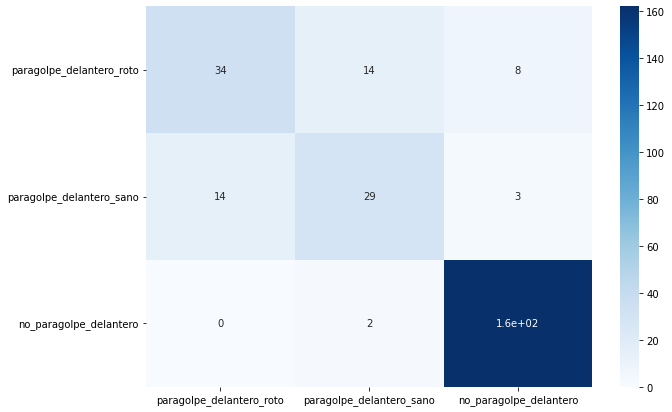

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
df_cm.to_csv('./trained_models/{}/{}/confusion_matrix.csv'.format(MODEL_NAME, EXPERIMENT_NAME))